In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score
import seaborn as sns
import h5py
np.random.seed(1234)

In [36]:
filename = "sample_2e7_design_precessing_higherordermodes_3detectors.h5"

h5 = h5py.File(filename, 'r')

In [37]:
print(h5.keys())

det=h5['det']

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>


In [38]:
downsampling = int(2e5)
random_indices = np.random.permutation(len(det))[:downsampling] # to be sure to not have correlation among data caused by positions
features=['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']
X = []
for feature in features:
    feature_data = h5[feature][:]
    X.append(feature_data[random_indices])

X = np.array(X).T
Y = np.array(h5['det'])[random_indices]

In [40]:
df = pd.DataFrame(X, columns=['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z'])

summary_stats = df.describe()
print(summary_stats)

               chi1x          chi1y          chi1z          chi2x  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.000218       0.000123       0.000148      -0.000571   
std         0.333162       0.333353       0.332590       0.332425   
min        -0.998477      -0.994557      -0.996876      -0.991650   
25%        -0.187177      -0.186697      -0.186332      -0.186956   
50%        -0.000069       0.000117       0.000055      -0.000207   
75%         0.186867       0.186687       0.187521       0.186183   
max         0.997413       0.998685       0.994338       0.996446   

               chi2y          chi2z            dec           iota  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.001303       0.000341      -0.000253       1.571963   
std         0.334193       0.331649       0.681579       0.683518   
min        -0.994476      -0.996780      -1.566364       0.006092   
25%        -0.185944      -0.1853

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

***Decision Trees***

In [6]:
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12]
}

tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'max_depth': 10}


In [7]:
dtree = DecisionTreeClassifier(max_depth=10,criterion='entropy', random_state = 42) 

In [8]:
dtree.fit(x_train, y_train)

y_pred = dtree.predict(x_test)

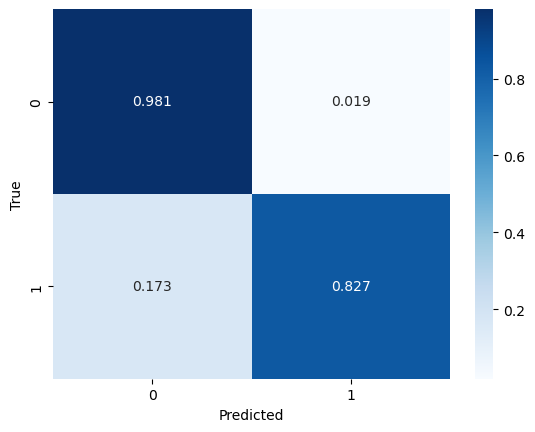

In [9]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9589


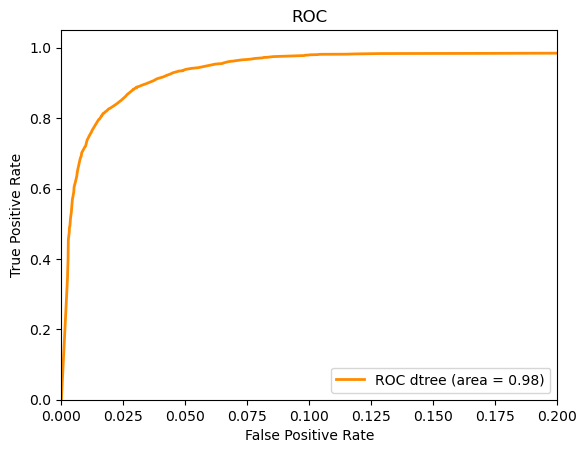

In [11]:
y_pred_proba = dtree.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC dtree (area = {auc:.2f})')

plt.xlim([0.0, 0.2])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')

***Random Forest***

In [12]:
# !!! This cell takes minutes to run !!!
param_grid = {
    'n_estimators': [50, 100, 200]
}

trees = RandomForestClassifier(max_depth=10)
grid_search = GridSearchCV(estimator=trees, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'n_estimators': 100}


In [12]:
forest = RandomForestClassifier(n_estimators=100, max_depth=10,criterion='entropy', random_state = 42)
forest.fit(x_train, y_train)

y_pred1 = forest.predict(x_test)

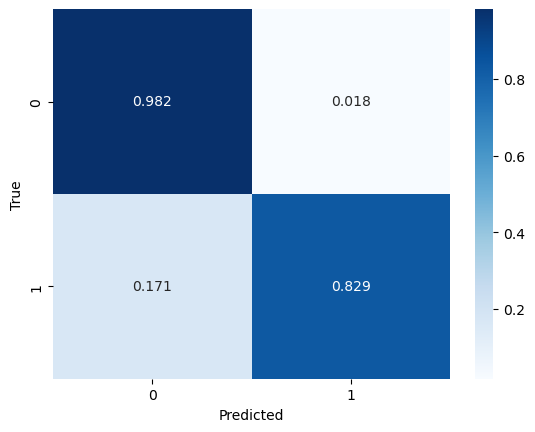

In [13]:
cm1 = confusion_matrix(y_test, y_pred1, normalize='true')
sns.heatmap(cm1, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy1}')

Accuracy: 0.9606


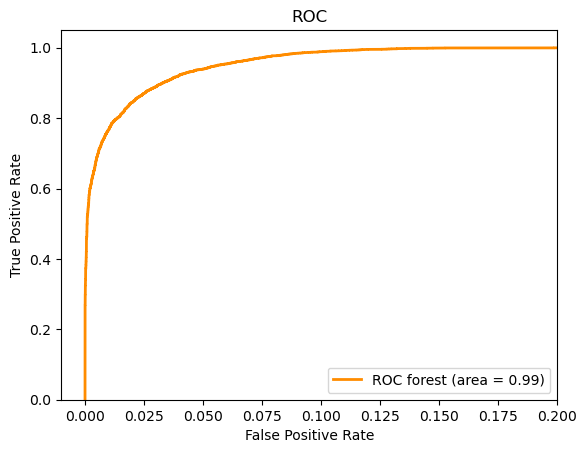

In [15]:
y_pred_proba1 = forest.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1)
auc = roc_auc_score(y_test, y_pred_proba1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC forest (area = {auc:.2f})')

plt.xlim([-0.01, 0.2])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')

In [17]:
recall_dtree= recall_score(y_test, y_pred)
contam_dtree = 1-precision_score(y_test, y_pred)
recall_1 = recall_score(y_test, y_pred1)
contam_1 = 1-precision_score(y_test, y_pred1)
print('completeness score Decision Tree: ', recall_dtree)
print('completeness score Random Forest: ', recall_1)
print('contamination score Decision Tree: ', contam_dtree)
print('contamination score Random Forest: ', contam_1)

completeness score Decision Tree:  0.8273977433004231
completeness score Random Forest:  0.8291607898448519
contamination score Decision Tree:  0.12411347517730498
contamination score Random Forest:  0.11431261770244816


What are the most important features that contribute to the result?

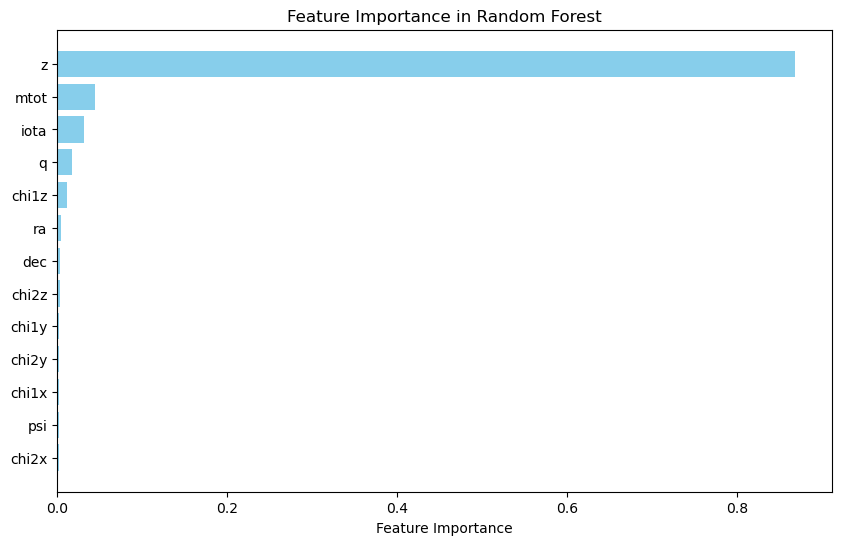

In [18]:
importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the df by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y axis to show the most important feature at the top
plt.show()

In [41]:
feature_importance_df.head(5)

,Feature,Importance
12,z,0.868398
8,mtot,0.045046
7,iota,0.031483
10,q,0.017413
2,chi1z,0.011841


Now I repeat Random Forest using the 5 most important features found above.

In [25]:
features_new=['chi1z', 'iota', 'mtot',  'q',  'z']
downsampling = int(2e5)
random_indices = np.random.permutation(len(det))[:downsampling] # to be sure to not have correlation among data caused by positions

X = []
for feature in features_new:
    feature_data = h5[feature][:]
    X.append(feature_data[random_indices])

X = np.array(X).T
Y = np.array(h5['det'])[random_indices]

In [26]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20]
}

trees = RandomForestClassifier()
grid_search = GridSearchCV(estimator=trees, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train_new, y_train_new)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'max_depth': 20, 'n_estimators': 200}


In [28]:
forest = RandomForestClassifier(n_estimators=200, max_depth=20,criterion='entropy', random_state = 42)
forest.fit(x_train_new, y_train_new)

y_pred_new = forest.predict(x_test_new)

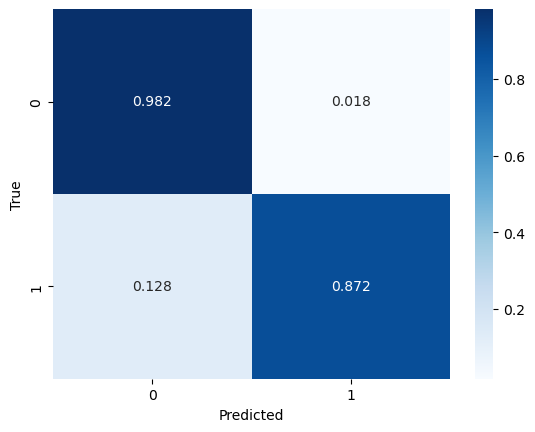

In [29]:
cm_new = confusion_matrix(y_test_new, y_pred_new, normalize='true')
sns.heatmap(cm_new, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
accuracy_new= accuracy_score(y_test_new, y_pred_new)
print(f'Accuracy: {accuracy_new}')

Accuracy: 0.966325


It's slightly better than the accuracy calculated using all the features! (0.9606 vs 0.966325)

***Support Vector Machines***

In [20]:
# !!! takes a lot to run !!!
param_grid = {
    'C': [0.1, 1, 10],
    'kernel' : ['rbf']
}

svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=1)

grid_search.fit(x_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'C': 0.1, 'kernel': 'rbf'}


In [21]:
svm = SVC(C=0.1, kernel='rbf', random_state=42)
svm.fit(x_train, y_train)
y_pred2 = svm.predict(x_test)

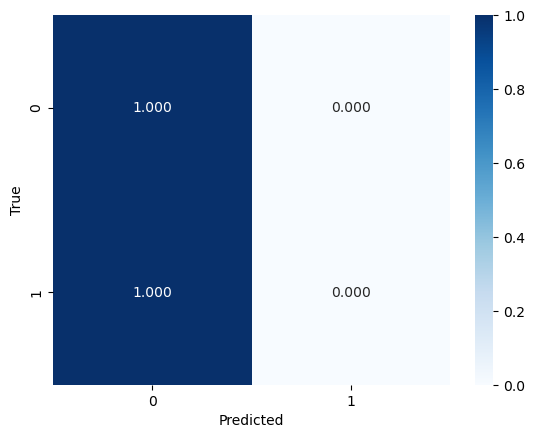

In [23]:
cm = confusion_matrix(y_test, y_pred2, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
accuracy2= accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2}')

Accuracy: 0.8582


Not a good model... I can clearly see from the confusion matrix that just one class is predicted, but the accuracy is still high! That's a proof that is better to not "trust" 100% the metric.